# Практическое задание

## Вычитание фона

### О задании

В данном задании вам предлагается самостоятельно реализовать алгоритм вычитания фона ViBe. Протестировать этот алгорит на датасете ChangeDetection 2014 года, а также сравнить качество его работы с алгоритмом, основанным на смеси гауссиан. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. Необходимо установить следующие пакеты: `numpy`, `skimage`, `opencv`. 

##  Часть 1

В этой части задания вам предстоит реализовать алгоритм вычитания фона *ViBe* и протестировать его качество работы на датасете *Change Detection 2014*.


**1. (3 балла)**

Прочитайте статью, выданную вам совместно с ноутбуком, описывающую алгоритм *ViBe* и реализуйте следующие его ключевые особенности: 
1. *Цветовая модель пикселей.* Для каждого пикселя хранится набор $\{p_1, ..., p_N\}$ - значений цвета данного пикселя в предыдущие моменты времени. 
2. *Классификация пикселей.* Для каждого нового кадра пиксель считается пикселем фона, если среди значений  $\{p_1, ..., p_N\}$ его цветовой модели содержится не менее K значений, расстояние до которых меньше радиуса R по евклидовой метрике.
3. *Обновления цветовой модели.* Если пиксель был классифицирован как пиксель фона, его цветовая модель обновляется следущий образом: случайно выбранная точка цветовой модели данного пикселя заменяется на новое значения. 
4. *Модель инициализации.* Иницилизируйте цветовую модель для каждого пикселя значением цвета пикселя на первом кадре, а также значениями цвета случайно выбранных соседей(используйте 4'x или 8'ми-связную модель соседства);

Дополните реализуйте следущую модификацию, предложенную этими же авторами позднее:
* "Random time subsampling". Во многих практических ситуациях нет необходимости обновлять фоновую модель каждого пикселя для каждого нового кадра. Если сделать фоновое обновление менее частым, мы искусственно продлеваем средний срок службы фоновых образцов и таким образом боремся со случайными движениями возникающими в кадре. "Random time subsampling" заключается в том что бы не обновлять фоновую модель для каждого пикселя после каждого кадра. А для каждому пикселю сопоставить случаюную величину, которая будет отвечать за то, чтобы обновлять модель данного пикселя или нет, так чтобы обновление произодило в среднем раз в `subsampling_time` кадров (т.е обновлять фоновую модель каждого пикселя с вероятностью `1 / subsampling_time`).

*Замечание*:

Для реализации модели Vibe используйте предоставленный шаблон. Реализация алгоритма на питоне будет работать медленно, поэтому старайтесь выполнять как можно больше вычислений матрично.

In [1]:
import os
from IPython import display

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from tqdm import tqdm
import random

In [2]:
class Vibe:
    def __init__(self, sample_amount, radius, K, subsampling_time):
        """
        'Visual Background Extractor' algorithm of background subtraction

        :param sample_amount: number of samples per pixel
        :param radius: radius of the sphere
        :param K: number of close samples for being part of background
        :param subsampling_time: amount of random subsampling
        """

        self.sample_amount = sample_amount
        self.radius = radius
        self.K = K
        self.subsampling_time = subsampling_time
        self.samples = None
        self.initial = 0


    def initialize(self, image):
        """
        Initialize the model with frame of video sequence.

        :param image: initializining frame
        """
        self.initial = 1
        self.samples = np.ones((image.shape[0],image.shape[1],self.sample_amount,image.shape[2]))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for k in range(self.sample_amount):
                    list_pixels = (image[max(0,i-1):min(i+1,image.shape[0]),max(0,j-1):min(j+1,image.shape[1])]).flatten()
                    rand = random.randint(0,(len(list_pixels)-1)//3)
                    self.samples[i,j,k] = list_pixels[rand*3:(rand+1)*3]
                    
    def apply(self, image):
        """
        Apply background subtraction algorithm to the next image,
        update internal parameters and return foreground mask.
        If model is not yet initialized, model must be initialized with this image.

        :param image: next image in video sequence
        :return: foreground mask
        """
        if self.initial == 0:
            self.initialize(image)
        foreground_mask = np.ones(image.shape[:2])
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if (np.sqrt(pow(self.samples[i,j,:,0] - image[i,j,0],2)+
                            pow(self.samples[i,j,:,1] - image[i,j,1],2)+
                            pow(self.samples[i,j,:,2] - image[i,j,2],2))<self.radius).sum()>self.K :
                    rand = random.randint(0,self.sample_amount-1)
                    self.samples[i,j,rand,:] = image[i,j,:]
                    foreground_mask[i,j] = 0
        return foreground_mask
                    

**2. (1 балл)**

Посмотрите как работает алгоритм на различных фрагментах видео из категориии Baseline датасета ChangeDetection2014, выданного вам совместно с ноутбуком. Поиграйтесь с параметрами и сделайте выводы.

Для визуализации покадрового применения алгоритма можете использовать код, написанный ниже.

*Замечание: *  
Полную версию датасета можно найти [здесь](http://changedetection.net/)

In [3]:
from skimage.util import random_noise,img_as_uint,img_as_float

def image_generator(dirpath, first_frame=1, last_frame=None,sigma = 1):
    """
    Generator of (frame_number, image, groundtruth) tuples.

    :param dirpath: Path to dir contained 'input' and 'groundtruth' subdirs
    :param first_frame: int, optional. Frame number from which the generator starts (inclusive)
    :param last_frame: int, optional. If provide, frame number  where the generator stops (inclusive)
    :return: (frame_number, image, groundtruth) tuples
    """

    input_format_name = 'input/in{:06d}.jpg'
    gt_format_name = 'groundtruth/gt{:06d}.png'

    numb = first_frame
    while (last_frame is None) or numb <= last_frame:
        input_path = os.path.join(dirpath, input_format_name.format(numb))
        gt_path = os.path.join(dirpath, gt_format_name.format(numb))

        if os.path.exists(input_path):
            input_image = skimage.io.imread(input_path)
            input_image = np.uint8(random_noise(img_as_float(input_image), var=(sigma/255)**2)*255.0)
            gt_image = skimage.io.imread(gt_path)
            if len(input_image.shape) == 2:
                input_image = input_image[..., np.newaxis]
            yield numb, input_image, gt_image
        else:
            break
        numb += 1
        
        
def apply_bg_substractor(bg_substractor, image_generator):
    """
    Apply background substruction algorithm for each frame of image_generator consistently

    :return: generator of (frame_number, frame, bg_substructor_mask, groundtruth) tuples
    """

    for numb, frame, gt in image_generator:
        mask = bg_substractor.apply(frame)
        yield numb, frame, mask, gt


def plot_bg_result(frame_number, frame, mask, gt, axs=None):
    """
    Draw frame, foreground mask, groundtruth mask images on axes.
    """
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(frame)
    axs[0].set_title("Frame: {}".format(frame_number))

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("BG result")

    axs[2].imshow(gt, cmap='gray')
    axs[2].set_title("Ground truth")

In [18]:
ff = 570
lf = 703
image_gen = image_generator('./dataset/baseline/office',first_frame = ff,last_frame = lf)

bg_substractor = Vibe(20,30,2,30)

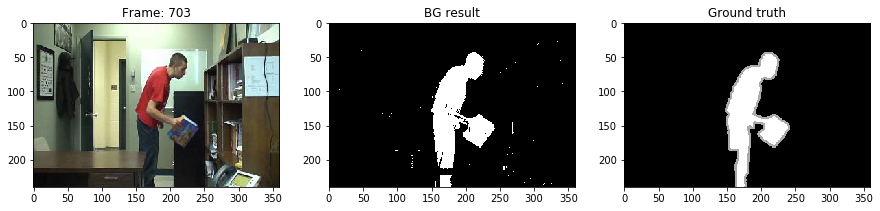

134it [02:53,  1.25s/it]


In [19]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**3. (1 балл)**

Визуально протестируйте алгоритм на видео из категории Baseline.  Покажите ключевые кадры и проанализируйте результаты.  Сделайте выводы о плюсах и минусах алгоритма. 

103it [01:43,  1.05it/s]
134it [02:29,  1.08s/it]


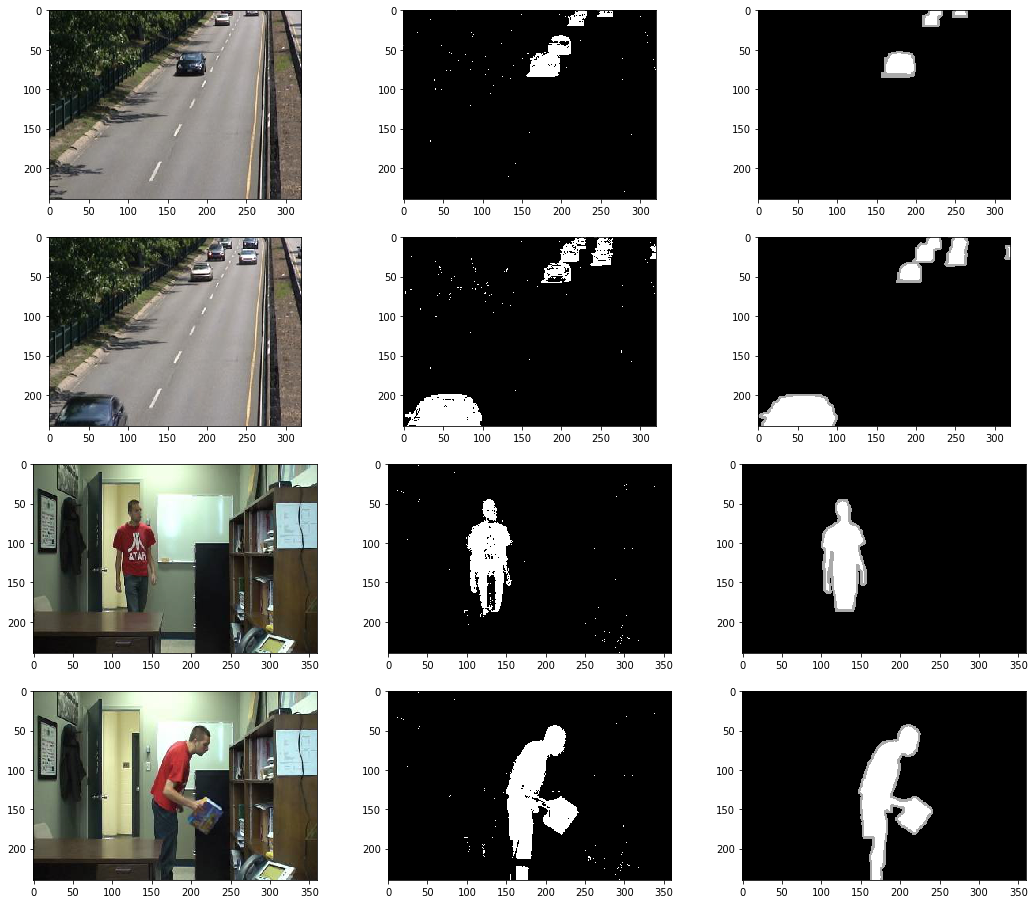

In [22]:
_, axs = plt.subplots(4, 3, figsize=(18, 4* 4), squeeze=False)

i=0
frames = [703,570,702,600]
for videos in ['highway','office']:
    input_path = os.path.join('./dataset/baseline/', videos)
    first_frame = frames.pop()
    last_frame = frames.pop()
    image_gen = image_generator(input_path,first_frame,last_frame,sigma =0)
    bg_substractor = Vibe(20,30,2,30)
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
        if (numb == last_frame)or(numb==630):
            axs[i][0].imshow(frame)
            axs[i][1].imshow(mask, cmap='gray')
            axs[i][2].imshow(gt, cmap='gray')
            i=i+1
plt.show()

**Выводы:**
В приведенных выше 4х кадрах мы видим 2 удачных и 2 неудачных.
В первом кадре, сравнивая с истинными резуьтатами gt,мы видим, что Vibe распознал машину, которой не было на исходном кадре.
Второй кадр же очень четко выделил каждую из машин, границы четкие, очень близки к gt.
Третий кадр сильно зашумлен, посередине брюк человека образовалась "дыра", на голове, шее и футболке потеряны границы.
Четвертый кадр же очень хорошо выделил как границы человек, так и внутренние точки.
+ алгоритма:
1.Четкое детектирование границ на кадрах с мноежством объектов
2.Нет выбросов шума или полное "исчезновение" объектов.
- алоритма:
1.При данном значении history = 20, медленный разгон.Это значит, что в первых 30+ кадрах наблюдается необычное поведение алгоритма(добавление несуществующих объектов, которые были на предыдущих кадрах)
2.Проблемы с стационарными участками цвета: брюки человека, хоть и находятся в движении, детектируются частично, без темной части.
3.В моей реализации виден шум "соль и перец", однако от него легко избавиться, например, медианным фильтром.

## Часть 2

В этой части задания вам необходимо реализовать метрики оценки качества вычитания фона, протестировать реализованый вами алгоритм Vibe на категории Baseline датасета ChangeDetection2014.


**4. (0.5 балла)**

Реализуйте следущие метрики:
\begin{equation*}
\begin{array}{l}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN} \\
F_1{\text -}score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{array}
\end{equation*}

In [4]:
def precision(confusion_matrix):
    """
    Compute the precision

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    return confusion_matrix[3]/(confusion_matrix[3]+confusion_matrix[1])


def recall(confusion_matrix):
    """
    Compute the recall

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    return confusion_matrix[3]/(confusion_matrix[3]+confusion_matrix[2])


def f1_score(confusion_matrix):
    """
    Compute the f1_score

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    rec = recall(confusion_matrix)
    prec = precision(confusion_matrix)
    # your code here
    return 2*(rec*prec)/(prec+rec)

**5. (2 балла) **

Посчитайте значение метрик качества $precision$, $recall$, $f_1{\text -}score$ для всех видео из категории Baseline. Также посчитайте среднее значение этих метрик по категории. Вам необходимо достичь среднего значения $f_1{\text -}score$ более 0.8 для категории Baseline.

*Замечание 1:*  
$TP$, $FP$, $FN$, $TP$ надо аккумулировать для всего видео, после чего надо вычислить значение метрик для каждого видео по описанным выше формулам и усреднить по всем видео из категории.

*Замечание 2:*  
В разметке встречаются следующие метки:
* 0 : Static
* 50 : Hard shadow
* 85 : Outside region of interest
* 170 : Unknown motion (usually around moving objects, due to semi-transparency and motion blur)
* 255 : Motion

При подсчет метрик качества вам необходимо учитывать только метки: 0 и 50 - это пиксели фона, и 255 - это пиксели переднего плана. Пиксели, содержащие метки 85 и 170 надо не учитывать при подсчете метрик качества.

In [19]:
#ff = 570
#lf = 703
ff = 570
lf = 800
const_images = ['office','highway','pedestrians','PETS2006']
pr_img =[]
rec_img =[]
f1_img=[]
for dir_image in const_images:
    image_gen = image_generator('./dataset/baseline/'+dir_image,first_frame = ff,last_frame = lf)
    bg_substractor = Vibe(20,30,2,30)
    rec_out = 0
    prec_out = 0
    f1_out = 0
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
        fp_loc = (gt[mask == 1] == 0).sum() + (gt[mask==1] == 50).sum()
        tn_loc = (gt[mask == 1] > 50).sum()
        tp_loc = (gt[mask == 0] == 0).sum() + (gt[mask==0] == 50).sum()
        fn_loc = (gt[mask == 0] > 50).sum()
        if tp_loc == 0:
            tp_loc = 0.8
        r_o = recall([tn_loc,fp_loc,fn_loc,tp_loc])
        rec_out+=r_o
        p_o=precision([tn_loc,fp_loc,fn_loc,tp_loc])
        prec_out+=p_o
        f_o=f1_score([tn_loc,fp_loc,fn_loc,tp_loc])
        f1_out+=f_o
        #print("Numb:",numb," rec:",r_o ," precis:",p_o," f1:",f_o )
    rec_img.append(rec_out /(lf-ff+1))
    pr_img.append(prec_out /(lf-ff+1))
    f1_img.append(f1_out /(lf-ff+1))
for i in range(len(const_images)):
    print(const_images[i]," !MEAN! rec:",rec_img[i] ," precis: ",pr_img[i]," f1: ",f1_img[i] )

178it [03:20,  1.10s/it]


office  !MEAN! rec: 0.989094634709361  precis:  0.997220044147391  f1:  0.9931376196950183
highway  !MEAN! rec: 0.985131614324342  precis:  0.9948005665901819  f1:  0.9899208430568509
pedestrians  !MEAN! rec: 0.9954562528293245  precis:  0.97255292746575  f1:  0.9838591290013862
PETS2006  !MEAN! rec: 0.9926379489086182  precis:  0.9913994380090195  f1:  0.9920048442695975


## Часть 3

В этой части задания вам предстоит протестировать алгоритм, основанный на смеси гауссиан из библиотеки `opencv`. Сравнить работу этого алгоритма с алгоритмом Vibe, а также посмотреть как ведут себя алгоритмы при добавление шума различной степени на изображение.


**6. (0.5 балл)**

Посмотрите как ведет себя алгоритм `MOG2` из библиотеки `opencv`. Аналогично как из с алгоритмом Vibe провизиализируйте покадровую работу алгоритма на какой-нибудь части видео и визуально оцените качество работы взависимости от параметров `history` и `varThreshhold`, параметр `detectShadows` установите равным False. Какие выводы вы можете сделать?

In [5]:
from cv2 import createBackgroundSubtractorMOG2

mog2 =  createBackgroundSubtractorMOG2(history = 1000,varThreshold=16,detectShadows = False)
image_gen = image_gen = image_generator('./dataset/baseline/office',first_frame = 570,last_frame =800,sigma = 0)

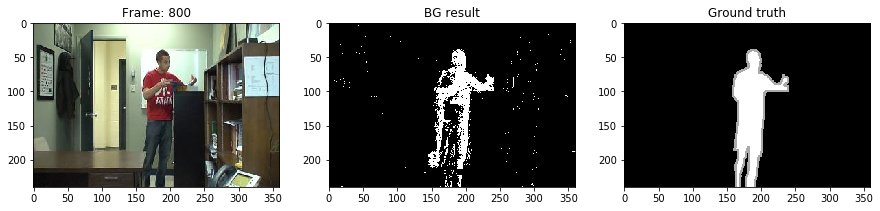

231it [00:46,  4.89it/s]


In [6]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen )):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**Выводы:**

...При увеличении параметра varTreshhold уменьшается кол-во шума, поэтому данный параметр устанавливает границу К соседей текущего пикселя, на основании которых принимается решение о его принадлежности к переднему плану
При малом параметре history в видеоряде мы видим периодическое "исчезание" человека, например, в кадрах перед тем, как человек наклоняется за книгой, и после, когда он стоит и читает книгу."Исчезание" происходит за счет малого изменения окрестных пикселей, человек, в течении некоторого времени, совершает мало движений.
При большом параметре history мы видим "след" человека.При движении появляются не только новые пиксели переднего фона,но и остаются с прошлых кадров,при этом, через несколько кадров, исчезая.При этом "исчезания" не происходит.
Основываясь на вышесказанных предположениях, можно сказать, что параметр history отвечает за количество предыдущих кадров, на основе которых мы можем делать о значении пикелей на новом кадре.
Также в данном алгоритме, на кадрах появляется много разряженного шума, и иногда возникают "всплески" (1 раз), когда шум покрывает около 30% всего кадра.

Если смотреть на алгоритм в целом,то однозначно его плюсом является скорость работы.
Главным минусом же - меньшая точность, по сравнению с Vibe.

**7. (1 балл)**

Выберите один кадр из набора ключевых кадров, отобранных ключевых кадрах в пункте 3 и добавляйте к
нему попиксельно независимый гауссовский шум. Проанализируйте результаты вычитания фона обоими методами для шума различной интенсивности. Подберите параметры алгоритмов для работы с зашумленными изображениями.  Визуализируйте результаты работы обоих алгоритмов а также вычислите $f_1{\text -}score$ для всех экспрериментов. Сделайте выводы.

*Замечание 1:*  
Сравнение проводите честно, подавайте в алгоритм одинаковое кол-во впереди идущих кадров, необходимых для настройки внутренних параметров алгоритма.

*Замечание 2:*  
Ко всем кадрам, подаваемым в модель, необходимо также добавлять гауссовский шум.

In [39]:
ff = 570
lf = 830
def get_mog2_result(sigma):
    """
    Apply MOG2 algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    mog2 =  createBackgroundSubtractorMOG2(history = 1000,varThreshold=16,detectShadows = False)
    img_gen1 = image_generator('./dataset/baseline/office/',first_frame = ff, last_frame = lf,sigma = sigma)
    for numb1, frame1, mask1, gt1 in tqdm(apply_bg_substractor(mog2, img_gen1)):
        if numb1 == lf:
            return frame1, mask1, gt1
    

def get_vibe_result(sigma):
    """
    Apply ViBe algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    bg_substractor = Vibe(20,30,2,30)
    img_gen = image_generator('./dataset/baseline/office/',first_frame = ff, last_frame = lf,sigma = sigma)
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, img_gen)):
        if numb == lf:
            return frame, mask, gt

def get_confusion_matrix(pred_mask, gt):
    fp_loc = (gt[pred_mask > 0] <= 50).sum()
    tn_loc = (gt[pred_mask > 0] > 50).sum()
    tp_loc = (gt[pred_mask == 0] <=50).sum()
    fn_loc = (gt[pred_mask == 0] > 50).sum()
    return [tn_loc,fp_loc,fn_loc,tp_loc]


0it [00:00, ?it/s]


166it [02:58,  1.04s/it]


66it [01:12,  1.04s/it]


7it [00:00, 64.63it/s]


156it [02:39,  1.00s/it]


45it [00:47,  1.05it/s]


228it [03:42,  1.04it/s]


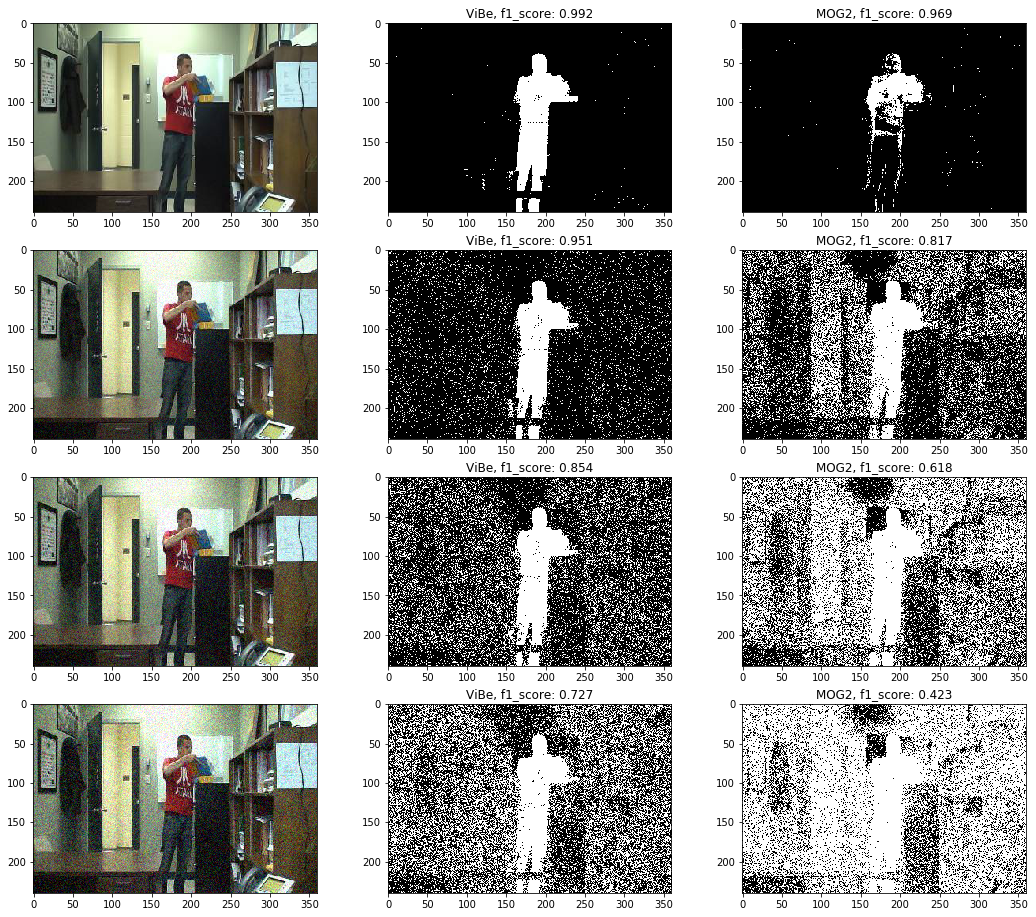

In [41]:
sigmas =[0, 15, 20, 25]
#sigmas = [0.12, 0.14, 0.16, 0.18]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, mog2_mask, gt = get_mog2_result(sigma)
    frame, vibe_mask, gt = get_vibe_result(sigma)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("ViBe, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    axs[i][2].imshow(mog2_mask, cmap='gray')
    axs[i][2].set_title("MOG2, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(mog2_mask, gt))))
plt.show()

**Выводы:**

При добавлении гауссовского шума на изображение мы наблюдаем резкое падение f1_score на обоих алгоритмах.
Однако в vibe падение f1_score более плавное, что подводит нас к выводу, что метод более устойчив при зашумлении.


**8. (1 балл)**

Предложите метод борьбы с шумом на карте "фон-объект" и проанализируйте его эффективность. Сравнивайте результаты по какой-нибудь метрики качества, например $f_1{\text -}score$.

*Замечание:*

Можно использовать любые функции обработки изображений из библиотек `opencv` и `skimage`.

In [42]:
from skimage.morphology import disk
from skimage.filters.rank import median
def post_process(mask):
    """
    Postprocessing foreground mask
    """
    return median(mask, disk(5))


0it [00:00, ?it/s]


180it [03:27,  1.11s/it]


94it [01:50,  1.11s/it]


8it [00:14,  1.53s/it]


181it [03:20,  1.08s/it]


91it [01:40,  1.06s/it]

92it [01:41,  1.06s/it]

93it [01:42,  1.05s/it]

94it [01:43,  1.05s/it]

95it [01:45,  1.06s/it]


258it [04:37,  1.06s/it]


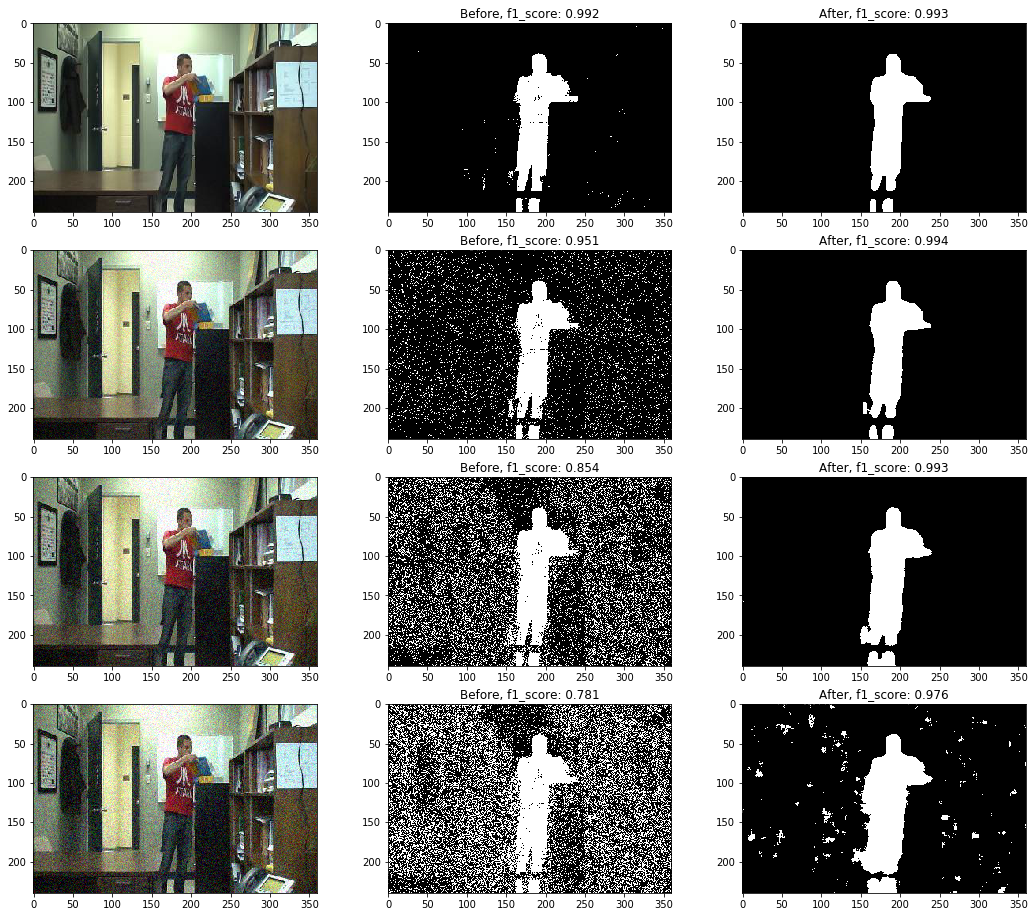

In [43]:
sigmas = [0, 15, 20, 23]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    process_mask = post_process(vibe_mask)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("Before, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(process_mask, cmap='gray')
    axs[i][2].set_title("After, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(process_mask, gt))))
plt.show()

**Выводы:**

Как мы видим, обычный медианный фильтр отлично помогает избавиться от шума на кадрах и улучшить показания f1_score.
Однако при сильном шуме(sigma >20), медианный фильтр не помогает и возникают ошибки.
Так, смотря на последнее изображение, мы видим, что выделяется не только область человека, но и "хлопья" по всему кадру.
Единственное,возникает вопрос по поводу реализации функций precision,recall,f1_score.
Если считать относительно фона, то значения f1_score колеблются около 0.97-0.99, однако не всегда полностью отображают то, что на самом деле выделяется передним планом.Если же считать относительно переднего плана, то возникают некорректные случаи, когда в gt просто находится черный кадр - всё является фоном.В таких случаях происходит деление на 0,а это некорректно, и приходится дополнительно инициализировать значение TP в таких случаях.
Это тоже не всегда корректно, так как темные кадры занимают достаточно значительный объем в некоторых видео.Поэтому было принято считать относительно фона и значение f1_score получаются очень большими.